# CS 285 Project Analysis

For general analysis and visualizing results from CS 285 final project experiments.

## Setup

### Imports

In [171]:
import json
import multiprocessing as mp
import os
import shutil

from collections import defaultdict
from collections import deque

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [141]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "m", "y", "c"])

### Constants

In [184]:
# general functional constants
SEEDS = [37, 42, 69]
VIDEOS = [0, 1, 99]
ENVIRONMENTS = ['cheetah', 'reacher', 'walker']
TRAIN_STEPS_1 = 80
TASK_MAP = {
    'cheetah': 'run',
    'reacher': 'easy',
    'walker': 'walk'
}

# constants for IK experiments w/o distractions
IK_EASY_LOG_ROOT = "/global/scratch/brianyao/DeepRL_Pretraining/pretraining/logs/easy/"
IK_EASY_TRAIN_LOG = IK_EASY_LOG_ROOT + "{}/ik_seed{}_steps{}k/train.log" # env, seed, steps in thousands
IK_EASY_TRAIN_LOG_BASE = IK_EASY_LOG_ROOT + "{}/ik_seed{}_steps{}k_baseline/train.log"
IK_EASY_MODEL_CONSOL = IK_EASY_LOG_ROOT + "models/{}_{}_{}" # env, seed, baseline or not
IK_EASY_MODEL = IK_EASY_LOG_ROOT + "{}/ik_seed{}_steps{}k/model/" # env, seed, steps in thousands
IK_EASY_MODEL_BASE = IK_EASY_LOG_ROOT + "{}/ik_seed{}_steps{}k_baseline/model/" # env, seed, steps in thousands

# constants for IK experiments w/ distractions
IK_HARD_LOG_ROOT = "/global/scratch/brianyao/DeepRL_Pretraining/pretraining/logs/hard/"
IK_HARD_TRAIN_LOG = IK_EASY_LOG_ROOT + "{}_distracted/ik_seed{}_steps{}k_video{}/train.log" # env, seed, steps in thousands, video
IK_HARD_TRAIN_LOG_BASE = IK_EASY_LOG_ROOT + "{}_distracted/ik_seed{}_steps{}k_video{}_baseline/train.log"

# constants for cross-env IK experiments
IK_CROSS_LOG_ROOT = "/global/scratch/brianyao/DeepRL_Pretraining/pretraining/logs/cross/"
IK_CROSS_TRAIN_LOG = IK_CROSS_LOG_ROOT + "{}_cross/ik_seed{}_steps{}k_cross{}/train.log"

# constants for reduced training set IK experiments
IK_REDUCED_LOG_ROOT = "/global/scratch/brianyao/DeepRL_Pretraining/pretraining/logs/reduced/"
IK_REDUCED_TRAIN_LOG = IK_REDUCED_LOG_ROOT + "{}_reduced/ik_seed{}_size{}/train.log"

# constants for reduced dataset size experiments
ENV_DATASET = "/global/scratch/brianyao/DeepRL_Pretraining/pretraining/env_data/{}_{}/" # env, dataset size
FULL_DATASET_SIZE = 200000
DATASET_SIZES = [5000, 10000, 20000]

# misc
CROSS_SCRIPT = "/global/scratch/brianyao/DeepRL_Pretraining/jobs/scripts/train/no_video_cross/20201210_train_{}_cross_{}_seed{}.sh"
CKPT_MAP = {
    'cheetah': "model_30_0.03330245401680148_0.018701719490285866.pth",
    'reacher': "model_30_0.012410615287178932_0.007526356643304611.pth",
    'walker': "model_30_0.09176280273681862_0.17047351044722092.pth"
}

REDUCED_SCRIPT = "/global/scratch/brianyao/DeepRL_Pretraining/jobs/scripts/train/no_video_reduced/20201213_train_{}_size_{}_seed{}.sh"
CKPT_MAP_REDUCED = {
    ('cheetah', 5000): "model_45_0.05076713316343926_0.0954778902232647.pth",
    ('reacher', 5000): "model_50_0.030293166637420654_0.11804138869047165.pth",
    ('walker', 5000): "model_20_0.2920221340011906_0.604458212852478.pth",
    ('cheetah', 10000): "model_50_0.04011470597942133_0.05648920933405558.pth",
    ('reacher', 10000): "model_50_0.02117622915554691_0.051516604920228325.pth",
    ('walker', 10000): "model_20_0.25041073298937566_0.38006024559338886.pth",
    ('cheetah', 20000): "model_50_0.03791938913432327_0.04402591979929379.pth",
    ('reacher', 20000): "model_50_0.017858832646664734_0.02473745641431638.pth",
    ('walker', 20000): "model_20_0.21746334715469465_0.2953632729394095.pth"
}
TOTAL_ENV_STEPS = 80000

### Functions

In [173]:
def rnd_copy(src, dest, num):
    """
    Copy num random .npy files from src directory to dest. (renumber files)
    src : str
        source directory
    dest : str
        destination directory
    num : str
        number of files to copy
    return : None
    """
    if not os.path.exists(dest):
        os.mkdir(dest)
    
    files = os.listdir(src)
    to_copy = np.random.choice(files, size=num, replace=False)
    
    cnt = 0
    for file in to_copy:
        shutil.copyfile(src + file, dest + "{}.npy".format(cnt))
        cnt += 1

In [153]:
def running_std(ts, s_avg):
    """
    Compute running standard deviation of length v_avg over ts.
    ts : []float
        time series
    s_avg : int
        length of std window
    return : []float
        ts of standard deviations
    """
    std_ts = []
    curr_window = deque(ts[:s_avg])
    for i in range(s_avg, len(ts)):
        std_ts.append(np.std(curr_window))
        curr_window.popleft()
        curr_window.append(ts[i])
    
    return std_ts

In [65]:
def ik_easy_ep_rwd(env, seeds, steps):
    """
    Generate curves for episode reward averaged across seeds for experiments on env with # steps.
    Compares baseline experiments with pretrained experiments.
    env : str
        environment name
    seeds : []int
        list of seeds
    steps : int
        number of train steps (in thousands)
    return : []float, []float
        time series of average rewards for baseline and pretrained
    """
    baseline_rewards = []
    pretrain_rewards = []
    for seed in seeds:
        if seed != 37 or (env != 'cheetah' and env != 'reacher'):
            filename = IK_EASY_TRAIN_LOG_BASE.format(env, seed, steps)
            curr_rewards = []
            with open(filename, 'r') as f:
                line = f.readline()
                while line:
                    line_d = json.loads(line[:-1])
                    curr_rewards.append(line_d['episode_reward'])
                    line = f.readline()

            baseline_rewards.append(curr_rewards)
        
        filename = IK_EASY_TRAIN_LOG.format(env, seed, steps)
        curr_rewards = []
        with open(filename, 'r') as f:
            line = f.readline()
            while line:
                line_d = json.loads(line[:-1])
                curr_rewards.append(line_d['episode_reward'])
                line = f.readline()
        pretrain_rewards.append(curr_rewards)

    mean_baseline_rewards = np.mean(baseline_rewards, axis=0)
    mean_pretrain_rewards = np.mean(pretrain_rewards, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.title("Mean Baseline v. Pretrain Rewards on {} (Seeds {})".format(env, ', '.join(map(str, seeds))))
    plt.plot(mean_baseline_rewards, label='baseline')
    plt.plot(mean_pretrain_rewards, label='pretrained')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.legend()
    plt.show()
    
    return mean_baseline_rewards, mean_pretrain_rewards

In [68]:
def ik_hard_ep_rwd(env, seeds, videos, steps):
    """
    Generate curves for episode reward averaged across seeds for distraction experiments on env with # steps.
    Compares baseline experiments with pretrained experiments.
    env : str
        environment name
    seeds : []int
        list of seeds
    videos : []int
        list of videos
    steps : int
        number of train steps (in thousands)
    return : []float, []float
        time series of average rewards for baseline and pretrained
    """
    baseline_rewards = []
    pretrain_rewards = []
    for video in videos:
        for seed in seeds:
            filename = IK_HARD_TRAIN_LOG_BASE.format(env, seed, steps, video)
            curr_rewards = []
            with open(filename, 'r') as f:
                line = f.readline()
                while line:
                    line_d = json.loads(line[:-1])
                    curr_rewards.append(line_d['episode_reward'])
                    line = f.readline()

            baseline_rewards.append(curr_rewards)

            filename = IK_HARD_TRAIN_LOG.format(env, seed, steps, video)
            curr_rewards = []
            with open(filename, 'r') as f:
                line = f.readline()
                while line:
                    line_d = json.loads(line[:-1])
                    curr_rewards.append(line_d['episode_reward'])
                    line = f.readline()
            pretrain_rewards.append(curr_rewards)

    mean_baseline_rewards = np.mean(baseline_rewards, axis=0)
    mean_pretrain_rewards = np.mean(pretrain_rewards, axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.title("Mean Distracted Baseline v. Pretrain Rewards on {} (Seeds {}, Videos {})" \
                  .format(env, ', '.join(map(str, seeds)), ', '.join(map(str, videos))))
    plt.plot(mean_baseline_rewards, label='baseline')
    plt.plot(mean_pretrain_rewards, label='pretrained')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.legend()
    plt.show()
    
    return mean_baseline_rewards, mean_pretrain_rewards

In [165]:
def ik_cross_ep_rwd(p_envs, r_env, seeds, steps, r_avg=1, s_avg=0):
    """
    Generate curves for reward averaged across seeds for experiments on r_env, pretrained on p_envs with # steps.
    Compares baseline experiments with pretrained experiments.
    p_env : []str
        pretrain environment names
    r_env : str
        rl environment name
    seeds : []int
        list of seeds
    steps : int
        number of train steps (in thousands)
    r_avg : int
        running average steps
    s_avg : int
        running std steps
    return : []float, []float
        time series of average rewards for baseline and pretrained
    """
    baseline_rewards = []
    pretrain_rewards = defaultdict(list)
    
    if s_avg:
        baseline_stds = []
        pretrain_stds = defaultdict(list)
    
    for seed in seeds:
        if seed == 37 and (r_env != 'cheetah' or r_env != 'reacher'):
            continue # edge case
        filename = IK_EASY_TRAIN_LOG_BASE.format(r_env, seed, steps)
        curr_rewards = []
        with open(filename, 'r') as f:
            line = f.readline()
            while line:
                line_d = json.loads(line[:-1])
                curr_rewards.append(line_d['episode_reward'])
                line = f.readline()

        curr_rewards = np.convolve(curr_rewards, np.ones(r_avg) / r_avg, mode='valid')
        baseline_rewards.append(curr_rewards)
        if s_avg:
            baseline_stds.append(running_std(curr_rewards, s_avg))
        
        for p_env in p_envs:
            if p_env == r_env: # not a cross-environment case
                filename = IK_EASY_TRAIN_LOG.format(r_env, seed, steps)
            else:
                filename = IK_CROSS_TRAIN_LOG.format(r_env, seed, steps, p_env)
            
            curr_rewards = []
            with open(filename, 'r') as f:
                line = f.readline()
                while line:
                    line_d = json.loads(line[:-1])
                    curr_rewards.append(line_d['episode_reward'])
                    line = f.readline()
            
            curr_rewards = np.convolve(curr_rewards, np.ones(r_avg) / r_avg, mode='valid')
            pretrain_rewards[p_env].append(curr_rewards)
            if s_avg:
                pretrain_stds[p_env].append(running_std(curr_rewards, s_avg))

    mean_baseline_rewards = np.mean(baseline_rewards, axis=0)
    mean_pretrain_rewards = {p_env: np.mean(pretrain_rewards[p_env], axis=0) for p_env in p_envs}
    if s_avg:
        mean_baseline_stds = np.mean(baseline_stds, axis=0)
        mean_pretrain_stds = {p_env: np.mean(pretrain_stds[p_env], axis=0) for p_env in p_envs}
    
    plt.figure(figsize=(10, 5))
    plt.title("{}-Step Running Mean Baseline and Pretrain Rewards on {}\nSeeds {}, Pretrained on {}" \
                  .format(r_avg, r_env, ', '.join(map(str, seeds)), ', '.join(map(str, p_envs))))
    plt.plot(mean_baseline_rewards, label='baseline')
    for p_env in p_envs:
        plt.plot(mean_pretrain_rewards[p_env], label='pretrained ({})'.format(p_env))
    plt.xlabel("Episode")
    plt.ylabel("Mean Episode Reward")
    plt.legend()
    plt.show()
    
    if s_avg:
        plt.figure(figsize=(10, 5))
        plt.title("Mean {}-Step Running SD of Baseline and Pretrain Rewards on {}\nSeeds {}, Pretrained on {}" \
                      .format(s_avg, r_env, ', '.join(map(str, seeds)), ', '.join(map(str, p_envs))))
        plt.plot(mean_baseline_stds, label='baseline')
        for p_env in p_envs:
            plt.plot(mean_pretrain_stds[p_env], label='pretrained ({})'.format(p_env))
        plt.xlabel("Episode")
        plt.ylabel("Mean Running STD")
        plt.legend()
        plt.show()
    
    return mean_baseline_rewards, mean_pretrain_rewards

## Analysis

### Visualize IK Pretraining Results

First, the no distractions case.

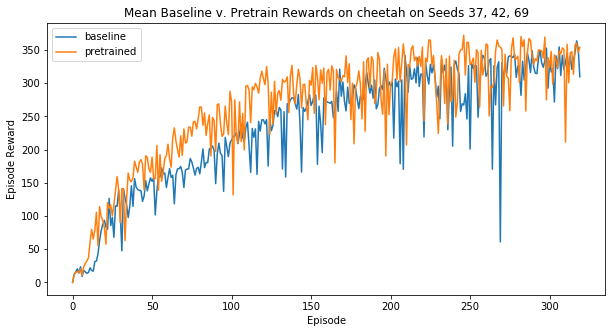

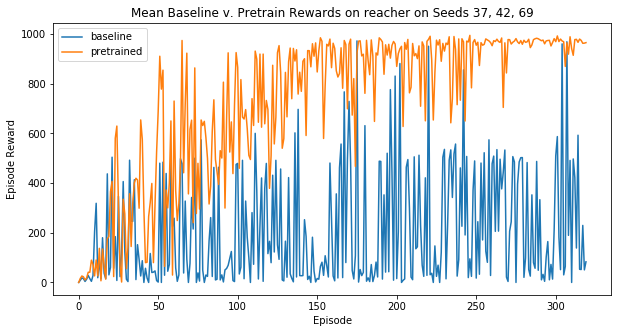

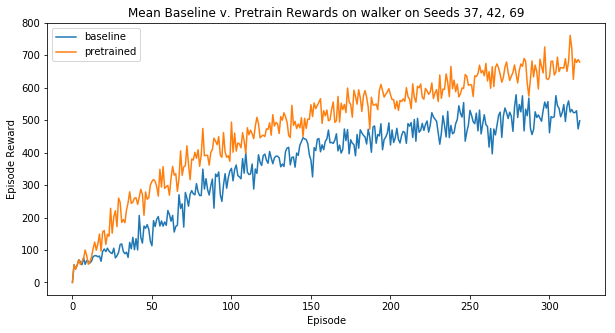

In [66]:
ik_easy_ep_rwds = {}
for env in ENVIRONMENTS:
    ik_easy_ep_rwds[env] = ik_easy_ep_rwd(env, SEEDS, TRAIN_STEPS_1)

Second, the case with distractions:

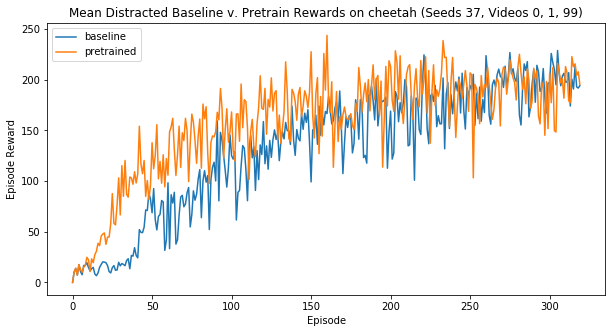

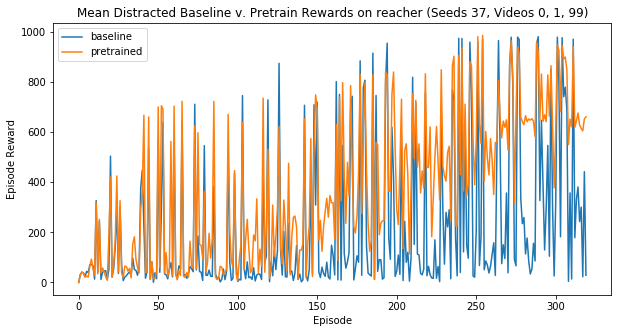

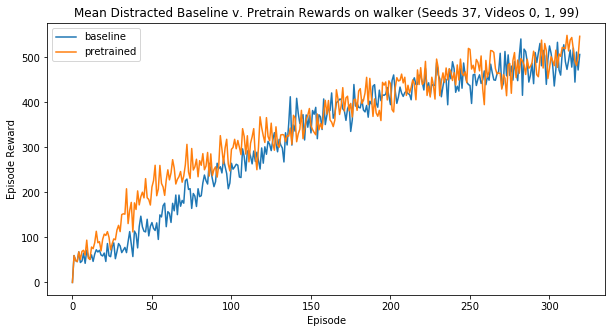

In [98]:
ik_hard_ep_rwds = {}
for env in ENVIRONMENTS:
    ik_hard_ep_rwds[(video, env)] = ik_hard_ep_rwd(env, [SEEDS[0]], VIDEOS, TRAIN_STEPS_1)

Thirdly, the cross-environment case:

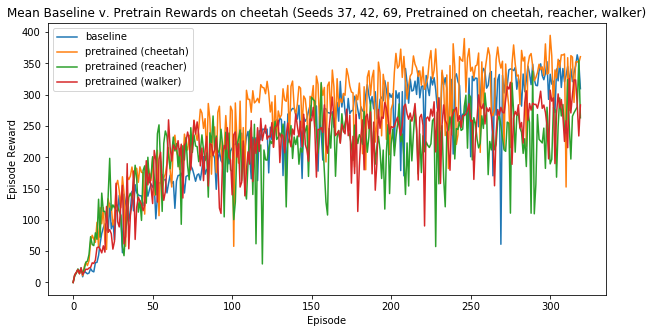

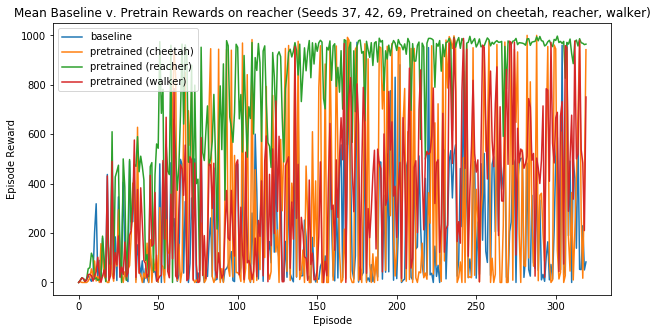

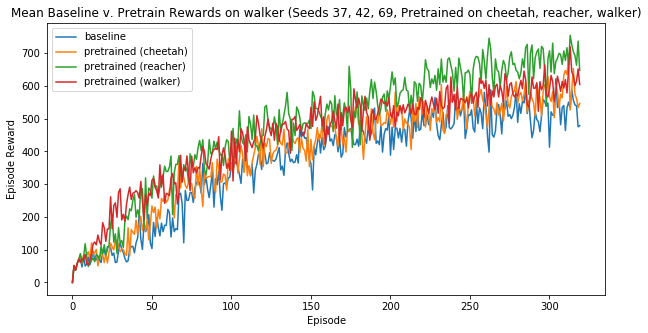

In [131]:
ik_cross_ep_rwds = {}
for env in ENVIRONMENTS:
    ik_cross_ep_rwds[env] = ik_cross_ep_rwd(ENVIRONMENTS, env, SEEDS, TRAIN_STEPS_1)

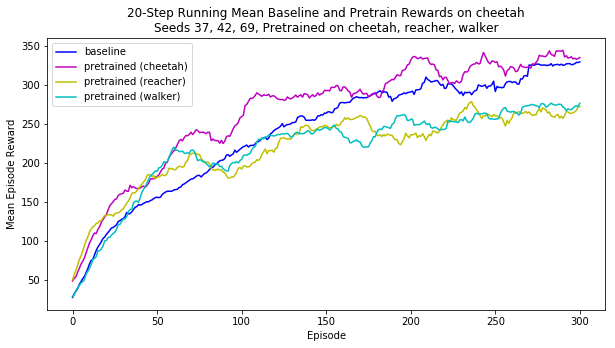

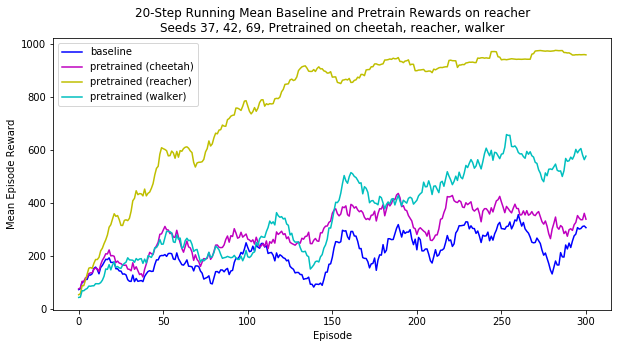

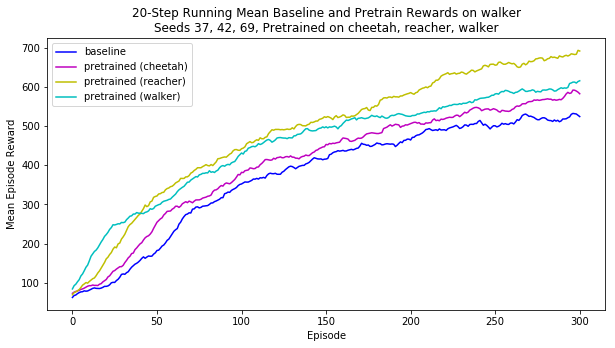

In [166]:
r_avg = 20
ik_cross_ep_rwds_ravg20 = {}
for env in ENVIRONMENTS:
    ik_cross_ep_rwds[env] = ik_cross_ep_rwd(ENVIRONMENTS, env, SEEDS, TRAIN_STEPS_1, r_avg)

### Collecting Models (for Sam)

In [61]:
for env in ENVIRONMENTS:
    for seed in SEEDS:
        if not (seed == 37 and env == 'cheetah') and not (seed == 37 and env == 'reacher'):
            shutil.copytree(IK_EASY_MODEL_BASE.format(env, seed, TRAIN_STEPS_1),
                            IK_EASY_MODEL_CONSOL.format(env, seed, "baseline"))
        shutil.copytree(IK_EASY_MODEL.format(env, seed, TRAIN_STEPS_1),
                        IK_EASY_MODEL_CONSOL.format(env, seed, "pretrain"))

### Cross-Environment Script Generation

In [84]:
fmt = """#!/bin/bash
export LD_LIBRARY_PATH=/global/software/sl-7.x86_64/modules/langs/python/3.6/lib

module load python/3.6
module load pytorch

cd /global/scratch/brianyao/DeepRL_Pretraining/src
python train.py \\
    --domain_name {} \\
    --task_name {} \\
    --action_repeat 4 \\
    --mode train \\
    --num_shared_layers 8 \\
    --num_filters 90 \\
    --seed {} \\
    --encoder_lr 1e-4 \\
    --actor_lr 1e-4 \\
    --critic_lr 1e-4 \\
    --replay_buffer_size 100000 \\
    --train_steps 80000 \\
    --work_dir /global/scratch/brianyao/DeepRL_Pretraining/pretraining/logs/{}_cross/ik_seed{}_steps80k_cross{} \\
    --encoder_checkpoint /global/scratch/brianyao/DeepRL_Pretraining/pretraining/ik_checkpoints/{}/{} \\
    --save_model"""

for env in ENVIRONMENTS:
    try:
        os.mkdir(IK_CROSS_LOG_ROOT + "{}_cross/".format(env))
    except FileExistsError:
        continue
    for seed in SEEDS:
        for p_env in ENVIRONMENTS:    
            try:
                os.mkdir(IK_CROSS_LOG_ROOT + "{}_cross/".format(env) + "ik_seed{}_steps80k_cross{}".format(seed, p_env))
            except FileExistsError:
                continue

for p_env in ENVIRONMENTS:
    for r_env in ENVIRONMENTS:
        if p_env == r_env:
            continue
        for seed in SEEDS:
            script_name = CROSS_SCRIPT.format(r_env, p_env, seed)
            task_name = TASK_MAP[r_env]
            ckpt_name = CKPT_MAP[p_env]
            script = fmt.format(
                r_env, 
                task_name,
                seed,
                r_env,
                seed,
                p_env,
                p_env,
                ckpt_name
            )

            with open(script_name, 'w') as f:
                f.write(script)

### Reduced Environment Data

In [176]:
args = []
for env in ENVIRONMENTS:
    for size in DATASET_SIZES:
        args.append((ENV_DATASET.format(env, FULL_DATASET_SIZE),
                     ENV_DATASET.format(env, size),
                     size))

pool = mp.Pool(mp.cpu_count())
with pool:
    pool.starmap(rnd_copy, args)

### Reduced Environment Data Script Generation

In [182]:
fmt = """#!/bin/bash
export LD_LIBRARY_PATH=/global/software/sl-7.x86_64/modules/langs/python/3.6/lib

module load python/3.6
module load pytorch

cd /global/scratch/brianyao/DeepRL_Pretraining/src
python train.py \\
    --domain_name {} \\
    --task_name {} \\
    --action_repeat 4 \\
    --mode train \\
    --num_shared_layers 8 \\
    --num_filters 90 \\
    --seed {} \\
    --encoder_lr 1e-4 \\
    --actor_lr 1e-4 \\
    --critic_lr 1e-4 \\
    --replay_buffer_size 100000 \\
    --train_steps {} \\
    --work_dir /global/scratch/brianyao/DeepRL_Pretraining/pretraining/logs/reduced/{}_reduced/ik_seed{}_size{} \\
    --encoder_checkpoint /global/scratch/brianyao/DeepRL_Pretraining/pretraining/ik_checkpoints/{}_{}/{} \\
    --save_model"""

for size in DATASET_SIZES:
    for env in ENVIRONMENTS:
        for seed in SEEDS:
            script_name = REDUCED_SCRIPT.format(env, size, seed)
            task_name = TASK_MAP[env]
            ckpt_name = CKPT_MAP_REDUCED[(env, size)]
            script = fmt.format(
                env, 
                task_name,
                seed,
                TOTAL_ENV_STEPS - size,
                env,
                seed,
                size,
                env,
                size,
                ckpt_name
            )

            with open(script_name, 'w') as f:
                f.write(script)